# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 33.08 MiB/s, done.
Resolving deltas: 100% (3/3), done.


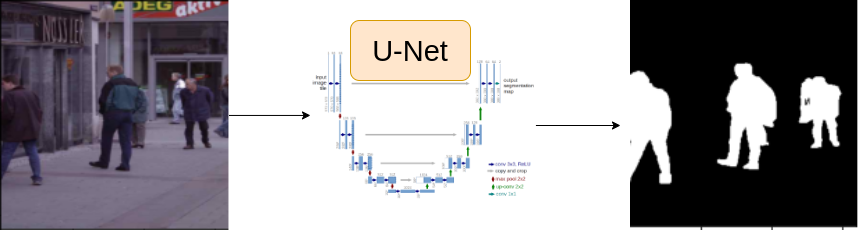

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255.0

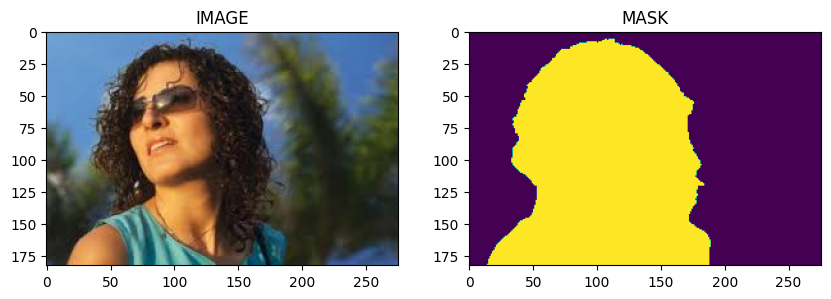

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegementationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))  # Resize mask to match image dimensions

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # (h, w, c) --> (c, h, w)
        mask = np.expand_dims(mask, axis=-1).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1))

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [14]:
trainset = SegementationDataset(train_df, get_train_augs())
validset = SegementationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


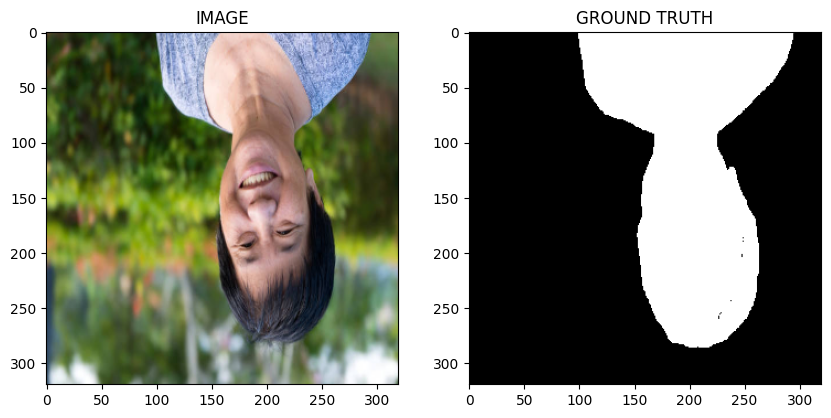

In [16]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as snp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = snp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 152MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f'Epock : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Saved Model
Epock : 1 Train_loss : 0.7121556659539541 Valid_loss : 1.1708258092403412


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Saved Model
Epock : 2 Train_loss : 0.37006737987200417 Valid_loss : 0.2928609363734722


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epock : 3 Train_loss : 0.29911364714304606 Valid_loss : 0.30104463174939156


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Saved Model
Epock : 4 Train_loss : 0.2690215994914373 Valid_loss : 0.21177910640835762


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


Epock : 5 Train_loss : 0.22350088655948638 Valid_loss : 0.2284855619072914


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epock : 6 Train_loss : 0.20996027191480002 Valid_loss : 0.2533149756491184


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epock : 7 Train_loss : 0.22362825671831768 Valid_loss : 0.21945273503661156


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Saved Model
Epock : 8 Train_loss : 0.19638190269470215 Valid_loss : 0.205801822245121


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epock : 9 Train_loss : 0.17145405113697051 Valid_loss : 0.22478600218892097


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epock : 10 Train_loss : 0.1509822800755501 Valid_loss : 0.2593526095151901


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epock : 11 Train_loss : 0.20141276915868123 Valid_loss : 0.2613021247088909


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epock : 12 Train_loss : 0.19380379915237428 Valid_loss : 0.21521834284067154


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epock : 13 Train_loss : 0.15584555019934973 Valid_loss : 0.2479194886982441


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epock : 14 Train_loss : 0.1178262934088707 Valid_loss : 0.2283269166946411


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epock : 15 Train_loss : 0.1395975684126218 Valid_loss : 0.2199307233095169


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epock : 16 Train_loss : 0.16483807315429053 Valid_loss : 0.2224356271326542


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epock : 17 Train_loss : 0.14261121153831482 Valid_loss : 0.2547328509390354


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Saved Model
Epock : 18 Train_loss : 0.15339538604021072 Valid_loss : 0.2025577798485756


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epock : 19 Train_loss : 0.12677140881617863 Valid_loss : 0.2073643710464239


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epock : 20 Train_loss : 0.11197670499483744 Valid_loss : 0.22049107775092125


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Epock : 21 Train_loss : 0.14152466207742692 Valid_loss : 0.280847892165184


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epock : 22 Train_loss : 0.1555368036031723 Valid_loss : 0.2503546141088009


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Saved Model
Epock : 23 Train_loss : 0.1081615924835205 Valid_loss : 0.17337984964251518


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epock : 24 Train_loss : 0.09617748310168585 Valid_loss : 0.17871231213212013


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

Epock : 25 Train_loss : 0.09949622104565302 Valid_loss : 0.17788835801184177


# Task 9 : Inference

In [28]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) --> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

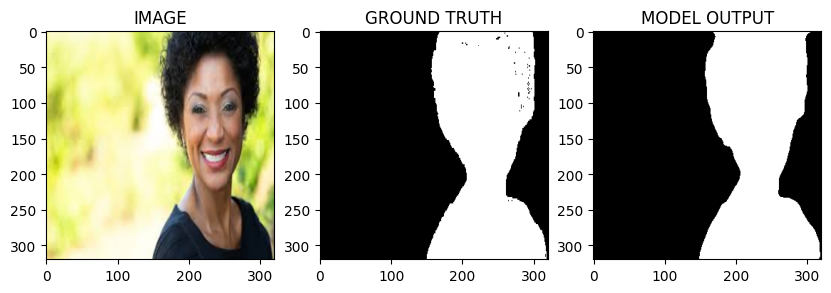

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))